/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


Epoch [1/20], Train Loss: 0.6751, Train Acc: 0.7572, Val Loss: 0.4881, Val Acc: 0.8187
Epoch [2/20], Train Loss: 0.4767, Train Acc: 0.8233, Val Loss: 0.4400, Val Acc: 0.8381
Epoch [3/20], Train Loss: 0.4295, Train Acc: 0.8408, Val Loss: 0.4174, Val Acc: 0.8453
Epoch [4/20], Train Loss: 0.4001, Train Acc: 0.8520, Val Loss: 0.4089, Val Acc: 0.8546
Epoch [5/20], Train Loss: 0.3811, Train Acc: 0.8576, Val Loss: 0.3910, Val Acc: 0.8593
Epoch [6/20], Train Loss: 0.3469, Train Acc: 0.8709, Val Loss: 0.3693, Val Acc: 0.8664
Epoch [7/20], Train Loss: 0.3390, Train Acc: 0.8726, Val Loss: 0.3698, Val Acc: 0.8662
Epoch [8/20], Train Loss: 0.3343, Train Acc: 0.8739, Val Loss: 0.3683, Val Acc: 0.8641
Epoch [9/20], Train Loss: 0.3284, Train Acc: 0.8759, Val Loss: 0.3626, Val Acc: 0.8671
Epoch [10/20], Train Loss: 0.3260, Train Acc: 0.8774, Val Loss: 0.3574, Val Acc: 0.8689
Epoch [11/20], Train Loss: 0.3247, Train Acc: 0.8782, Val Loss: 0.3628, Val Acc: 0.8663
Epoch [12/20], Train Loss: 0.3220, Train 

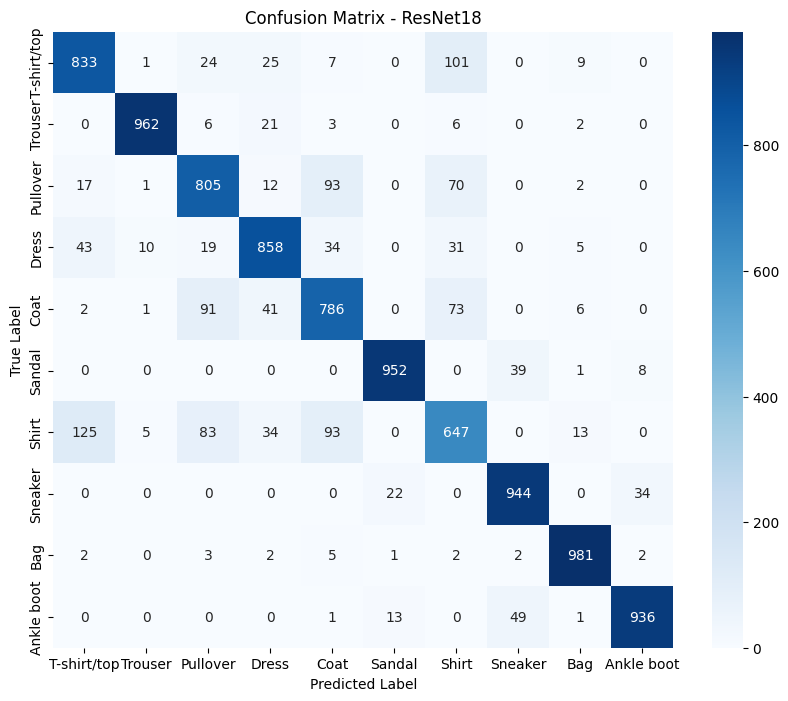

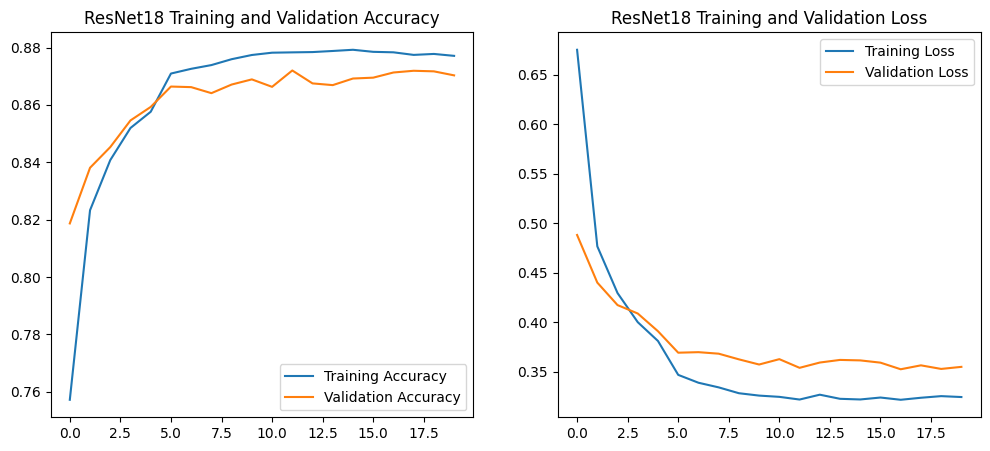

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define constants
batch_size = 64
num_classes = 10
num_epochs = 20  # Increased number of epochs
learning_rate = 0.0001  # Lowered learning rate for fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation and transformation: Resize, convert to RGB, and normalize
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
    transforms.Resize((32, 32)),                    # Resize to 32x32 for ResNet
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.RandomRotation(10),                  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize RGB channels
])

# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet18 model
resnet_model = models.resnet18(pretrained=True)

# Unfreeze the last few layers for fine-tuning
for param in resnet_model.parameters():
    param.requires_grad = False

# Unfreeze the last residual block and fully connected layer
for param in resnet_model.layer4.parameters():
    param.requires_grad = True

# Replace the final fully connected layer with a new one for 10 classes
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

# Define loss and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Step the learning rate scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate the model on test data
resnet_model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'ResNet18 Test accuracy: {test_accuracy:.4f}')

# Confusion Matrix for ResNet18
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ResNet18')
plt.show()

# Plot accuracy and loss curves for ResNet18
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ResNet18 Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('ResNet18 Training and Validation Loss')

plt.show()


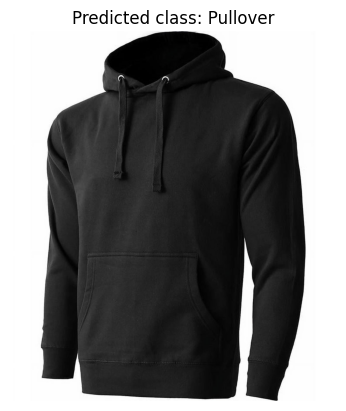

Top 5 predictions for /content/pullover.jpg:
Pullover: 0.4925
Shirt: 0.2335
T-shirt/top: 0.1229
Coat: 0.0976
Trouser: 0.0351

------------------------------



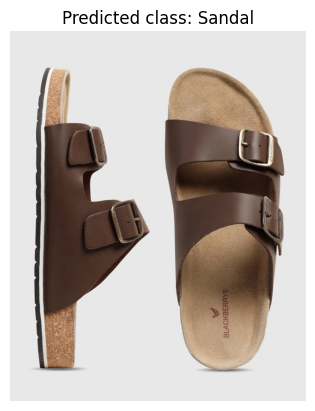

Top 5 predictions for /content/sl.webp:
Sandal: 0.9924
Trouser: 0.0061
T-shirt/top: 0.0011
Bag: 0.0001
Ankle boot: 0.0001

------------------------------



In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_images(image_paths, model, transform, device, class_names):
    # Iterate through each image path
    for image_path in image_paths:
        # Load and transform the image
        image = Image.open(image_path).convert("RGB")  # Open and convert image to RGB
        image_transformed = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
        image_transformed = image_transformed.to(device)  # Move to the appropriate device

        # Set model to evaluation mode
        model.eval()

        # Make the prediction
        with torch.no_grad():
            outputs = model(image_transformed)

            # Calculate probabilities
            probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities

            # Get the top 5 predictions and their probabilities
            top_probabilities, top_indices = torch.topk(probabilities, 5)

        # Get the predicted class
        predicted_class = class_names[top_indices[0][0].item()]

        # Display the image
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.title(f'Predicted class: {predicted_class}')
        plt.show()

        # Print the top 5 predicted classes and their probabilities
        print(f'Top 5 predictions for {image_path}:')
        for i in range(5):
            class_name = class_names[top_indices[0][i].item()]
            probability = top_probabilities[0][i].item()  # Get the probability
            print(f'{class_name}: {probability:.4f}')
        print('\n' + '-'*30 + '\n')  # Separator between images

# Example usage
image_paths = ['/content/pullover.jpg', '/content/sl.webp']  # List of paths to the images to be predicted
class_names = train_dataset.classes     # List of class names in the dataset
predict_images(image_paths, resnet_model, transform, device, class_names)
